# load module and dataest 

In [48]:
# Import libraries
from bs4 import BeautifulSoup
import os
import nltk
# nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [33]:


html_tables = {}

# For every table in the datasets folder...
for table_name in os.listdir('datasets'):
    #this is the path to the file. Don't touch!
    table_path = f'datasets/{table_name}'
    # Open as a python file in read-only mode
    table_file = open(table_path, 'r',encoding="utf-8")
    # Read the contents of the file into 'html'
    html = BeautifulSoup(table_file)
    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id="news-table")
    # Add the table to our dictionary
    html_tables[table_name] = html_table

# 分析data

In [34]:

# Read one single day of headlines 
tsla = html_tables['tsla_22sep.html']
# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
tsla_tr = tsla.findAll('tr')

# For each row...
for i, table_row in enumerate(tsla_tr):
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text()
    # Read the text of the element 'td' into 'data_text'
    data_text = table_row.td.get_text()
    # Print the count
    print(f'{i}:')
    # Print the contents of 'link_text' and 'data_text' 
    print(link_text)
    print(data_text)
    # The following exits the loop after three rows to prevent spamming the notebook, do not touch
    if i == 3:
        break

0:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
1:
Broadcoms Stock Looks Like a Winner
09:30PM  
2:
SHAREHOLDER ALERT:  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
3:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


# 得到1.公司名稱 2.日期 3.時間 4.新聞標題

### 依序說明parsed_news list各個資料取得方法:
* ticker股票名稱從html_tables可知在第一個位置
```python
ticker = file_name.split(‘_’)[0]
```
* 由上一張不清楚的截圖可以看到當同一個日期時，只有第一則新聞顯示日期，因此利用if else 查看date_scrape的長度便可知道當天第一個新聞是哪則。

* headline在標籤<a>內

In [35]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text() 
        headline = x.a.get_text()
        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split()
        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        if  len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, headline])
parsed_news[:3]

[['fb',
  'Jan-04-19',
  '06:22PM',
  'Facebook, Apple, Netflix, Amazon and Alphabet Power Friday Gains'],
 ['fb',
  'Jan-04-19',
  '05:15PM',
  'Earnings Reports for the Week of Jan. 7-11 (BBBY, KBH)'],
 ['fb',
  'Jan-04-19',
  '04:55PM',
  'COLUMN-Commentary: 2019 will be the year of more state control']]

# 請出NLTK情感分析專家維達大師
現在要請出NLTK情感分析專家維達大師幫忙分析新聞標題的情感，
使用Vader SentimentAnalyzer 這個情感模塊可以分析文字的情緒，分類有正面、負面和中性極性分類。

其中，compound表示複雜程度，neu表示中性，neg表示負面情緒，pos表示正面情緒。

### redefine word
本來"Crush 粉碎" 跟 "Beat 擊敗"本來在日常對話中通常表示負面的情緒，

但在市場中 crush/beat the market 代表在市場中大勝利多，

因此我們要更改或增加一些詞彙的情緒權重分數到情緒詞彙字典裡，讓情感分析大師分析股市新聞能更準確。

In [36]:
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

# 對新聞標題做情感分析

In [37]:

import pandas as pd
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)
# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames
scored_news = pd.concat([scored_news, scores_df], axis=1)
# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

scored_news 

,ticker,date,time,headline,neg,neu,pos,compound
0,fb,2019-01-04,06:22PM,"Facebook, Apple, Netflix, Amazon and Alphabet ...",0.000,0.631,0.369,0.4767
1,fb,2019-01-04,05:15PM,Earnings Reports for the Week of Jan. 7-11 (BB...,0.000,1.000,0.000,0.0000
2,fb,2019-01-04,04:55PM,COLUMN-Commentary: 2019 will be the year of mo...,0.000,1.000,0.000,0.0000
3,fb,2019-01-04,04:53PM,3 Tech Trends to Watch in 2019,0.000,1.000,0.000,0.0000
4,fb,2019-01-04,04:30PM,Will Denver's tech growth continue in 2019?,0.000,0.698,0.302,0.3818
...,...,...,...,...,...,...,...,...
495,tsla,2018-11-16,08:31AM,VW says could build up to 15 million electric ...,0.000,1.000,0.000,0.0000
496,tsla,2018-11-16,08:12AM,Elon Musk to Prowl Production Lines in Push fo...,0.000,1.000,0.000,0.0000
497,tsla,2018-11-16,06:39AM,Tesla cuts prices on solar power systems as it...,0.155,0.845,0.000,-0.2960
498,tsla,2018-11-16,06:00AM,Tesla Stretch Pushes Customers to Open Wallets...,0.000,1.000,0.000,0.0000


# 將公司市場情緒轉換為圖表

**把相同天的情緒做avg**

In [38]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date', 'ticker']).mean()
mean_c

neg       neu       pos  compound
date       ticker                                        
2018-09-18 fb      0.104864  0.843682  0.051455 -0.052564
           tsla    0.112875  0.807688  0.079438 -0.085650
2018-09-19 fb      0.072920  0.805560  0.121640  0.057568
           tsla    0.066732  0.879244  0.054000 -0.025949
2018-09-20 fb      0.059567  0.870233  0.070200  0.018447
           tsla    0.067304  0.762609  0.170087  0.148757
2018-09-21 fb      0.052762  0.886381  0.060857  0.014310
           tsla    0.102150  0.813900  0.083950 -0.030190
2018-09-22 fb      0.000000  0.899000  0.101000  0.255300
2018-11-16 tsla    0.022000  0.931810  0.046190  0.026714
2018-11-17 tsla    0.000000  0.916500  0.083500  0.190900
2018-11-18 tsla    0.000000  0.956667  0.043333  0.067433
2018-11-19 tsla    0.093263  0.821105  0.085632  0.002384
2018-11-20 tsla    0.014154  0.941308  0.044538  0.066862
2018-11-21 tsla    0.056091  0.821273  0.122636  0.162045
2018-11-22 tsla    0.370000  0.630000  0.000000 -0.637260
2018-11-23 tsla    0.040000  0.920000  0.040000  0.000000
2018-11-25 tsla    0.052750  0.801500  0.145750  0.046725
2018-11-26 tsla    0.107833  0.828111  0.064056 -0.103317
2018-12-28 fb      0.146909  0.816273  0.036818 -0.120973
2018-12-29 fb      0.102333  0.836333  0.061333 -0.024933
2018-12-30 fb      0.033667  0.817167  0.149167  0.173817
2018-12-31 fb      0.152267  0.760000  0.087800 -0.076540
2019-01-01 fb      0.000000  0.791667  0.208333  0.291667
2019-01-02 fb      0.023857  0.882762  0.093381  0.080748
           tsla    0.183714  0.717449  0.098918 -0.095986
2019-01-03 fb      0.089250  0.817700  0.093050  0.045855
           tsla    0.142045  0.826682  0.031273 -0.131786
2019-01-04 fb      0.066524  0.858286  0.075190  0.015771
           tsla    0.031034  0.899345  0.069621  0.060776

* stack：將資料的列“旋轉”為行
* unstack：將資料的行“旋轉”為列

In [39]:
# Unstack the column ticker
mean_c = mean_c.unstack(level=1)
mean_c

neg                 neu                 pos            \
ticker            fb      tsla        fb      tsla        fb      tsla   
date                                                                     
2018-09-18  0.104864  0.112875  0.843682  0.807688  0.051455  0.079438   
2018-09-19  0.072920  0.066732  0.805560  0.879244  0.121640  0.054000   
2018-09-20  0.059567  0.067304  0.870233  0.762609  0.070200  0.170087   
2018-09-21  0.052762  0.102150  0.886381  0.813900  0.060857  0.083950   
2018-09-22  0.000000       NaN  0.899000       NaN  0.101000       NaN   
2018-11-16       NaN  0.022000       NaN  0.931810       NaN  0.046190   
2018-11-17       NaN  0.000000       NaN  0.916500       NaN  0.083500   
2018-11-18       NaN  0.000000       NaN  0.956667       NaN  0.043333   
2018-11-19       NaN  0.093263       NaN  0.821105       NaN  0.085632   
2018-11-20       NaN  0.014154       NaN  0.941308       NaN  0.044538   
2018-11-21       NaN  0.056091       NaN  0.821273       NaN  0.122636   
2018-11-22       NaN  0.370000       NaN  0.630000       NaN  0.000000   
2018-11-23       NaN  0.040000       NaN  0.920000       NaN  0.040000   
2018-11-25       NaN  0.052750       NaN  0.801500       NaN  0.145750   
2018-11-26       NaN  0.107833       NaN  0.828111       NaN  0.064056   
2018-12-28  0.146909       NaN  0.816273       NaN  0.036818       NaN   
2018-12-29  0.102333       NaN  0.836333       NaN  0.061333       NaN   
2018-12-30  0.033667       NaN  0.817167       NaN  0.149167       NaN   
2018-12-31  0.152267       NaN  0.760000       NaN  0.087800       NaN   
2019-01-01  0.000000       NaN  0.791667       NaN  0.208333       NaN   
2019-01-02  0.023857  0.183714  0.882762  0.717449  0.093381  0.098918   
2019-01-03  0.089250  0.142045  0.817700  0.826682  0.093050  0.031273   
2019-01-04  0.066524  0.031034  0.858286  0.899345  0.075190  0.069621   

            compound            
ticker            fb      tsla  
date                            
2018-09-18 -0.052564 -0.085650  
2018-09-19  0.057568 -0.025949  
2018-09-20  0.018447  0.148757  
2018-09-21  0.014310 -0.030190  
2018-09-22  0.255300       NaN  
2018-11-16       NaN  0.026714  
2018-11-17       NaN  0.190900  
2018-11-18       NaN  0.067433  
2018-11-19       NaN  0.002384  
2018-11-20       NaN  0.066862  
2018-11-21       NaN  0.162045  
2018-11-22       NaN -0.637260  
2018-11-23       NaN  0.000000  
2018-11-25       NaN  0.046725  
2018-11-26       NaN -0.103317  
2018-12-28 -0.120973       NaN  
2018-12-29 -0.024933       NaN  
2018-12-30  0.173817       NaN  
2018-12-31 -0.076540       NaN  
2019-01-01  0.291667       NaN  
2019-01-02  0.080748 -0.095986  
2019-01-03  0.045855 -0.131786  
2019-01-04  0.015771  0.060776

#  指取得compound那欄
The compound score is the sum of positive, negative & neutral scores 

which is then normalized between -1(most extreme negative) and +1 (most extreme positive).

In [40]:
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis=1)
mean_c

ticker,fb,tsla
date,,
2018-09-18,-0.052564,-0.085650
2018-09-19,0.057568,-0.025949
2018-09-20,0.018447,0.148757
2018-09-21,0.014310,-0.030190
2018-09-22,0.255300,NaN
2018-11-16,NaN,0.026714
2018-11-17,NaN,0.190900
2018-11-18,NaN,0.067433
2018-11-19,NaN,0.002384


<AxesSubplot:xlabel='date'>

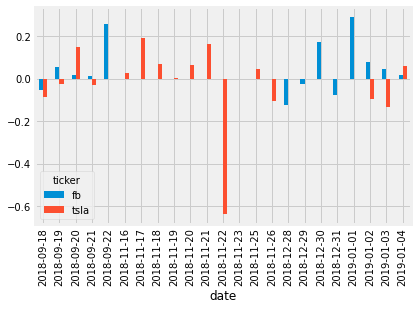

In [41]:

# Plot a bar chart with pandas

mean_c.plot.bar()

# 檢查為何2018 11 22那麼低  -->因為標題重複

In [42]:
import datetime
scored_news[scored_news['date'] == datetime.date(2018, 11, 22)]

,ticker,date,time,headline,neg,neu,pos,compound
426,tsla,2018-11-22,08:23AM,Tesla Cuts China Car Prices: Can Others Surviv...,0.196,0.804,0.0,-0.2960
427,tsla,2018-11-22,03:55AM,[$$] Tesla cuts prices in China as trade war b...,0.433,0.567,0.0,-0.7269
428,tsla,2018-11-22,01:24AM,Tesla Lowers Car Prices in China After Trade W...,0.463,0.537,0.0,-0.7096
429,tsla,2018-11-22,01:02AM,Tesla cuts China car prices to absorb hit from...,0.379,0.621,0.0,-0.7269
430,tsla,2018-11-22,12:30AM,Tesla cuts China car prices to absorb hit from...,0.379,0.621,0.0,-0.7269


# 過濾重複的data

In [43]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news['headline'].count()
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['ticker', 'headline'])
# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean['headline'].count()
# Print before and after numbers to get an idea of how we did 
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 476'

D:\anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,ticker,date,time,headline,neg,neu,pos,compound
426,tsla,2018-11-22,08:23AM,Tesla Cuts China Car Prices: Can Others Surviv...,0.196,0.804,0.0,-0.2960
427,tsla,2018-11-22,03:55AM,[$$] Tesla cuts prices in China as trade war b...,0.433,0.567,0.0,-0.7269
428,tsla,2018-11-22,01:24AM,Tesla Lowers Car Prices in China After Trade W...,0.463,0.537,0.0,-0.7096
429,tsla,2018-11-22,01:02AM,Tesla cuts China car prices to absorb hit from...,0.379,0.621,0.0,-0.7269


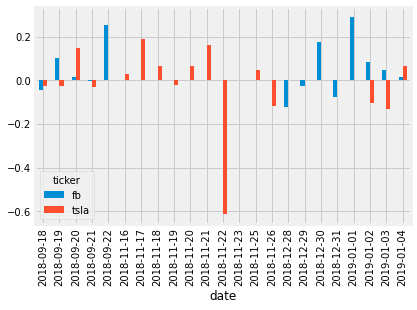

In [44]:
mean_clean = scored_news_clean.groupby(['date', 'ticker']).mean()
mean_clean = mean_clean.unstack(level=1)
mean_clean = mean_clean.xs('compound', axis=1)
mean_clean.plot.bar()
scored_news_clean[scored_news['date'] == datetime.date(2018, 11, 22)]

# 查看臉書單一交易日的股票市場行情 
看臉書單一交易日2019.1.9隨著時間的走勢，觀察市場情緒變化的趨勢如何。

In [55]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
single_day

time                                           headline  \
ticker date                                                                     
fb     2019-01-04  06:22PM  Facebook, Apple, Netflix, Amazon and Alphabet ...   
       2019-01-04  05:15PM  Earnings Reports for the Week of Jan. 7-11 (BB...   
       2019-01-04  04:55PM  COLUMN-Commentary: 2019 will be the year of mo...   
       2019-01-04  04:53PM                     3 Tech Trends to Watch in 2019   
       2019-01-04  04:30PM        Will Denver's tech growth continue in 2019?   
...                    ...                                                ...   
tsla   2018-11-16  08:31AM  VW says could build up to 15 million electric ...   
       2018-11-16  08:12AM  Elon Musk to Prowl Production Lines in Push fo...   
       2018-11-16  06:39AM  Tesla cuts prices on solar power systems as it...   
       2018-11-16  06:00AM  Tesla Stretch Pushes Customers to Open Wallets...   
       2018-11-16  05:00AM  Meet the man who runs Teslas Gigafactory 2 in ...   

                     neg    neu    pos  compound  
ticker date                                       
fb     2019-01-04  0.000  0.631  0.369    0.4767  
       2019-01-04  0.000  1.000  0.000    0.0000  
       2019-01-04  0.000  1.000  0.000    0.0000  
       2019-01-04  0.000  1.000  0.000    0.0000  
       2019-01-04  0.000  0.698  0.302    0.3818  
...                  ...    ...    ...       ...  
tsla   2018-11-16  0.000  1.000  0.000    0.0000  
       2018-11-16  0.000  1.000  0.000    0.0000  
       2018-11-16  0.155  0.845  0.000   -0.2960  
       2018-11-16  0.000  1.000  0.000    0.0000  
       2018-11-16  0.000  1.000  0.000    0.0000  

[476 rows x 6 columns]

In [56]:

# Cross-section the fb row
single_day = single_day.loc['fb'] #指取fb
# Select the 3rd of January of 2019
single_day = single_day.loc['2019-01-01'] #指取2019/01/03
# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time'])
single_day['time'] = single_day.time.dt.time 
# Set the index to time and 
single_day = single_day.set_index('time') #將 index設成time
# Sort it
single_day = single_day.sort_index(ascending=True) #照時間sorting
single_day

,headline,neg,neu,pos,compound
time,,,,,
00:00:00,2018: A Year in Review for a Roller-Coaster Ma...,0.0,1.000,0.000,0.000
09:21:00,20 Realistic Tech Predictions for 2019 -- Part...,0.0,1.000,0.000,0.000
22:48:00,Google wins U.S. approval for radar-based hand...,0.0,0.375,0.625,0.875


# 將臉書單一交易日的股票市場行情視覺化
這邊做圖可以看得比較細，把positive跟negative跟neutral這些subscore合在一起看。

Text(0, 0.5, 'scores')

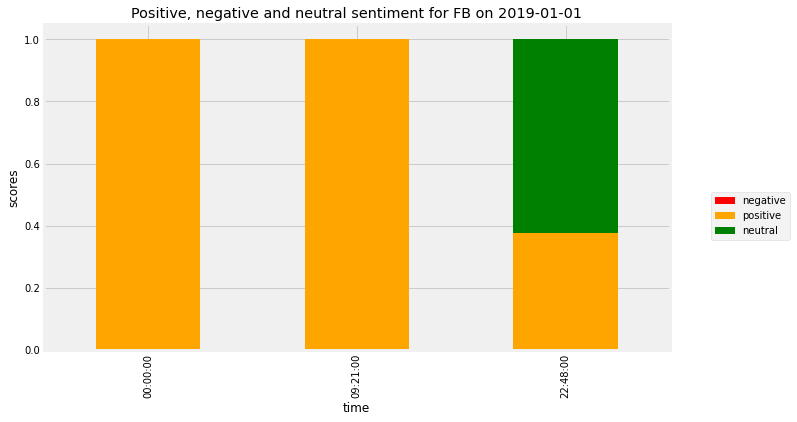

In [57]:
TITLE = "Positive, negative and neutral sentiment for FB on 2019-01-01"
COLORS = ["red", "orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['headline', 'compound'], axis=1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'positive', 'neutral']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, 
                  figsize=(10, 6), 
                  title = TITLE, 
                  color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores")

